# EDA ver2 : 
- 한자 전처리

# **setting**

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle

#import os
#os.chdir('./data')
#os.getcwd()

In [2]:
def preprocessing_dataset(dataset):
    """처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entity = []
    object_entity = []

    for i, j in tqdm(zip(dataset["subject_entity"], dataset["object_entity"]), desc="preprocessing"):
        i = i[1:-1].split(",")[0].split(":")[1]
        j = j[1:-1].split(",")[0].split(":")[1]

        subject_entity.append(i)
        object_entity.append(j)

    out_dataset = pd.DataFrame(
        {
            "id": dataset["id"],
            "sentence": dataset["sentence"],
            "subject_entity": subject_entity,
            "object_entity": object_entity,
            "label": dataset["label"],
        }
    )
    return out_dataset


def load_data(dataset_dir):
    """csv 파일을 경로에 맡게 불러 옵니다."""
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)

    return dataset

def label_to_num(label):
    num_label = []
    with open("/opt/ml/code/dict_label_to_num.pkl", "rb") as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label

In [3]:
train_path = '/opt/ml/dataset/train/train.csv'
total_data = load_data(train_path)
# total_data.columns

preprocessing: 32470it [00:00, 381303.57it/s]


In [4]:
train_data = total_data.sample(frac=0.9, random_state=42)
val_data = total_data.drop(train_data.index)

train_label = label_to_num(train_data["label"].values)
val_label = label_to_num(val_data["label"].values)

In [5]:
#train_data

# **EDA : Hanja preprocessing**   

> 한자 확인하기 :   
>> 한자 포함된 데이터 : 2073 rows   
>> subject_entitiy : 2 rows   
>> object_entity : 147 rows
   
   - 한자는 대체적으로 사람 이름이 많았음.

**한자가 포함된 데이터만 서칭****   

In [6]:
import re
def language_searching(dataset):          # datafreame
    redataset = pd.DataFrame()
    sub = pd.DataFrame()
    obj = pd.DataFrame()
    
    for ind in dataset.index:
        search_language = re.compile('([一-鿕]|[㐀-䶵]|[豈-龎])+')
        result = search_language.findall(dataset.loc[ind]['sentence'] or dataset.loc[ind]['subject_entity'] or dataset.loc[ind]['object_entity'])
        result_sub = search_language.findall(dataset.loc[ind]['subject_entity'])
        result_obj = search_language.findall(dataset.loc[ind]['object_entity'])
        
        if result :
            redataset = redataset.append(dataset.loc[ind],ignore_index = True)
        if result_sub :
            sub = sub.append(dataset.loc[ind],ignore_index = True)
        if result_obj :
            obj = obj.append(dataset.loc[ind],ignore_index = True)
            
    return redataset,sub,obj

In [7]:
hanja_total,hanja_sub,hanja_obj = language_searching(train_data)
hanja_total
# 2074 rows 


,id,label,object_entity,sentence,subject_entity
0,22493.0,per:title,'전라북도지사',송하진 전라북도지사는 “삼락농정 농업人 농촌in 수상작 전시회는 농업․농촌의 우수한...,'송하진'
1,18560.0,per:other_family,'김약선',"고려 원종의 비 순경태후의 외할아버지로, 전주 김씨 김약선(金若先)이 그의 맏사위였다.",'순경태후'
2,28540.0,no_relation,'르네상스',"미켈란젤로도 조각가·화가·건축가·해부학자이자 동시에 시인이기도 하였으며, 이 점에서...",'미켈란젤로'
3,27528.0,per:date_of_birth,'1989년 6월 13일',"양준아(梁準我, 1989년 6월 13일 ~)는 대한민국의 축구 선수로서 포지션은 미...",'양준아'
4,29563.0,per:title,'스페인 왕비',그녀의 대모(代母)는 당시 스페인 왕비 바텐베르크의 빅토리아 에우헤니아였다.,'바텐베르크의 빅토리아 에우헤니아'
...,...,...,...,...,...
2069,31748.0,org:alternate_names,'CCTV',중국에서는 중국중앙텔레비전(CCTV)의 어린이 전문 채널인 CCTV-14 채널을 통...,'중국중앙텔레비전'
2070,32117.0,per:date_of_birth,'1988년 3월 28일',"백다은(白多恩, (姜恩惠)(姜恩惠), 1988년 3월 28일 ~ )은 대한민국의 배...",'백다은'
2071,24282.0,per:date_of_death,'234년',"구수왕(仇首王, ~ 234년, 재위: 214년 ~ 234년)은 백제의 제6대 국왕이다.",'구수왕'
2072,29181.0,no_relation,'500명',20일 정오，주마카오부대 사령관 류유에(劉粤)의 약 500명의 부대원들이 주하이 주...,'마카오'


In [8]:
# hanja_sub
# 2 rows

In [9]:
# hanja_obj
# 147 rows 

## **라벨 분포 : Hanja**   

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def view_count(dataset,labels : str):
    # count 분포
    view = sns.countplot(data=dataset,x=labels,order = dataset[labels].value_counts().index)
    # label명 표시
    view.set_xticklabels(view.get_xticklabels(), rotation=90)

    # 각 막대에 숫자 표시
    for p in view.patches:
        height = p.get_height()
        view.text(p.get_x() + p.get_width() / 2., height + 3, int(height), ha = 'center', size = 6.5)

    plt.show()
    return 

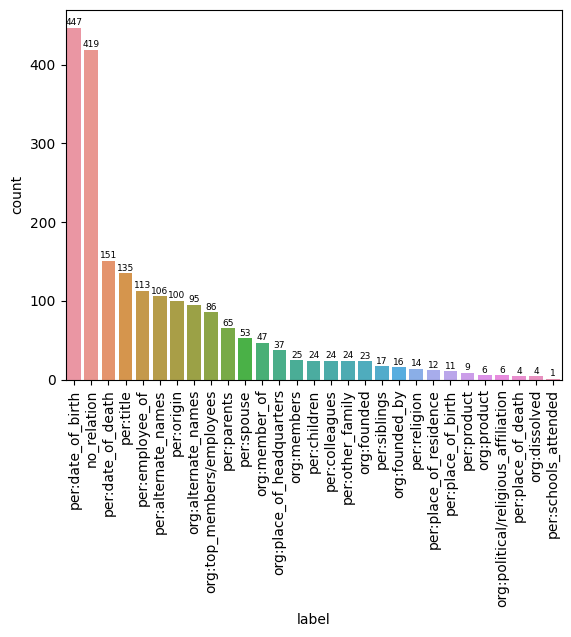

In [12]:
# dataset : hanja_total
# labels : 'lable'
view_count(hanja_total,'label')

# **Pre-Processing**   
### **Hanja preprocessing**   
> 한자 형태 바꾸기 :    
>> 㐀 -> (한자)

In [13]:
import re

In [14]:
hanja = re.compile('([一-鿕]|[㐀-䶵]|[豈-龎])+')
replace = '(한자)'
re_train_data = train_data.replace(hanja,replace)

In [15]:
#re_train_data

# **성능 테스트**
- model : klue/roberta-base
- batch_size: 16, max_epoch: 3, learning_rate: 1e-5

| model | test_accuracy | test_auprc | test_f1 |
| --- | --- | --- | --- |
| base | 0.8094 | 72.465 | 82.546 |
| hanja | 0.8054 | 72.93 | 82.222 |

## **결과**
- 한자 전처리한 모델(roberta-base_hanja_16_1e-05) : test_auprc 0.465 향상
- 하지만 test_accuracy,test_f1는 기존 데이터 모델이 더 높은 점수를 가짐.
- 유의미한 결과로 판단되지 않음 > 기존 데이터 활용